In [2]:
import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import numpy as np
from saliency.gradcam import GradCam, superimpose, fuse_layers, grad_cam_plus
from utils import create_model
from CONFIG import CONFIG
import numpy as np

from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore
from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus
from matplotlib import cm

/home/lorenzoquerol/miniconda3/envs/wssv-recognition/lib/python3.9/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [3]:
TEST_DIR = "dataset/augmented/test"
CLASS_NAMES = ["healthy", "wssv"]

test_dataset = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR,
    seed=CONFIG["seed_value"],
    image_size=CONFIG["img_shape"],
    batch_size=CONFIG["batch_size"],
    label_mode="categorical",
).prefetch(buffer_size=tf.data.AUTOTUNE)

test_images = []
test_labels = []
for X, y in test_dataset.as_numpy_iterator():
    test_images.append(X)
    test_labels.append(y)

test_images = np.concatenate(test_images)
test_labels = np.argmax(np.concatenate(test_labels), axis=1)

replace2linear = ReplaceToLinear()
X = np.asarray(test_images)
test_labels = list(test_labels)
score = CategoricalScore(test_labels)

Found 13 files belonging to 2 classes.


2023-06-12 01:25:46.270673: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-12 01:25:46.455015: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-12 01:25:46.455097: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-12 01:25:46.459155: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-12 01:25:46.459217: I tensorflow/compile

# EfficientNetV2B0 Saliency

In [4]:
checkpoint_filepath = "checkpoints/efficientnetv2b0"
latest = tf.train.latest_checkpoint(checkpoint_filepath)

EFFICIENTNET_MODEL = tf.keras.applications.EfficientNetV2B0(
    input_shape=CONFIG["input_shape"],
    include_top=False,
    classes=CONFIG["num_classes"],
)

model = create_model(EFFICIENTNET_MODEL, CONFIG)
model.load_weights(latest).expect_partial()

2023-06-12 01:25:51.615357: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [13]
	 [[{{node Placeholder/_4}}]]
2023-06-12 01:25:51.615651: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [13]
	 [[{{node Placeholder/_4}}]]


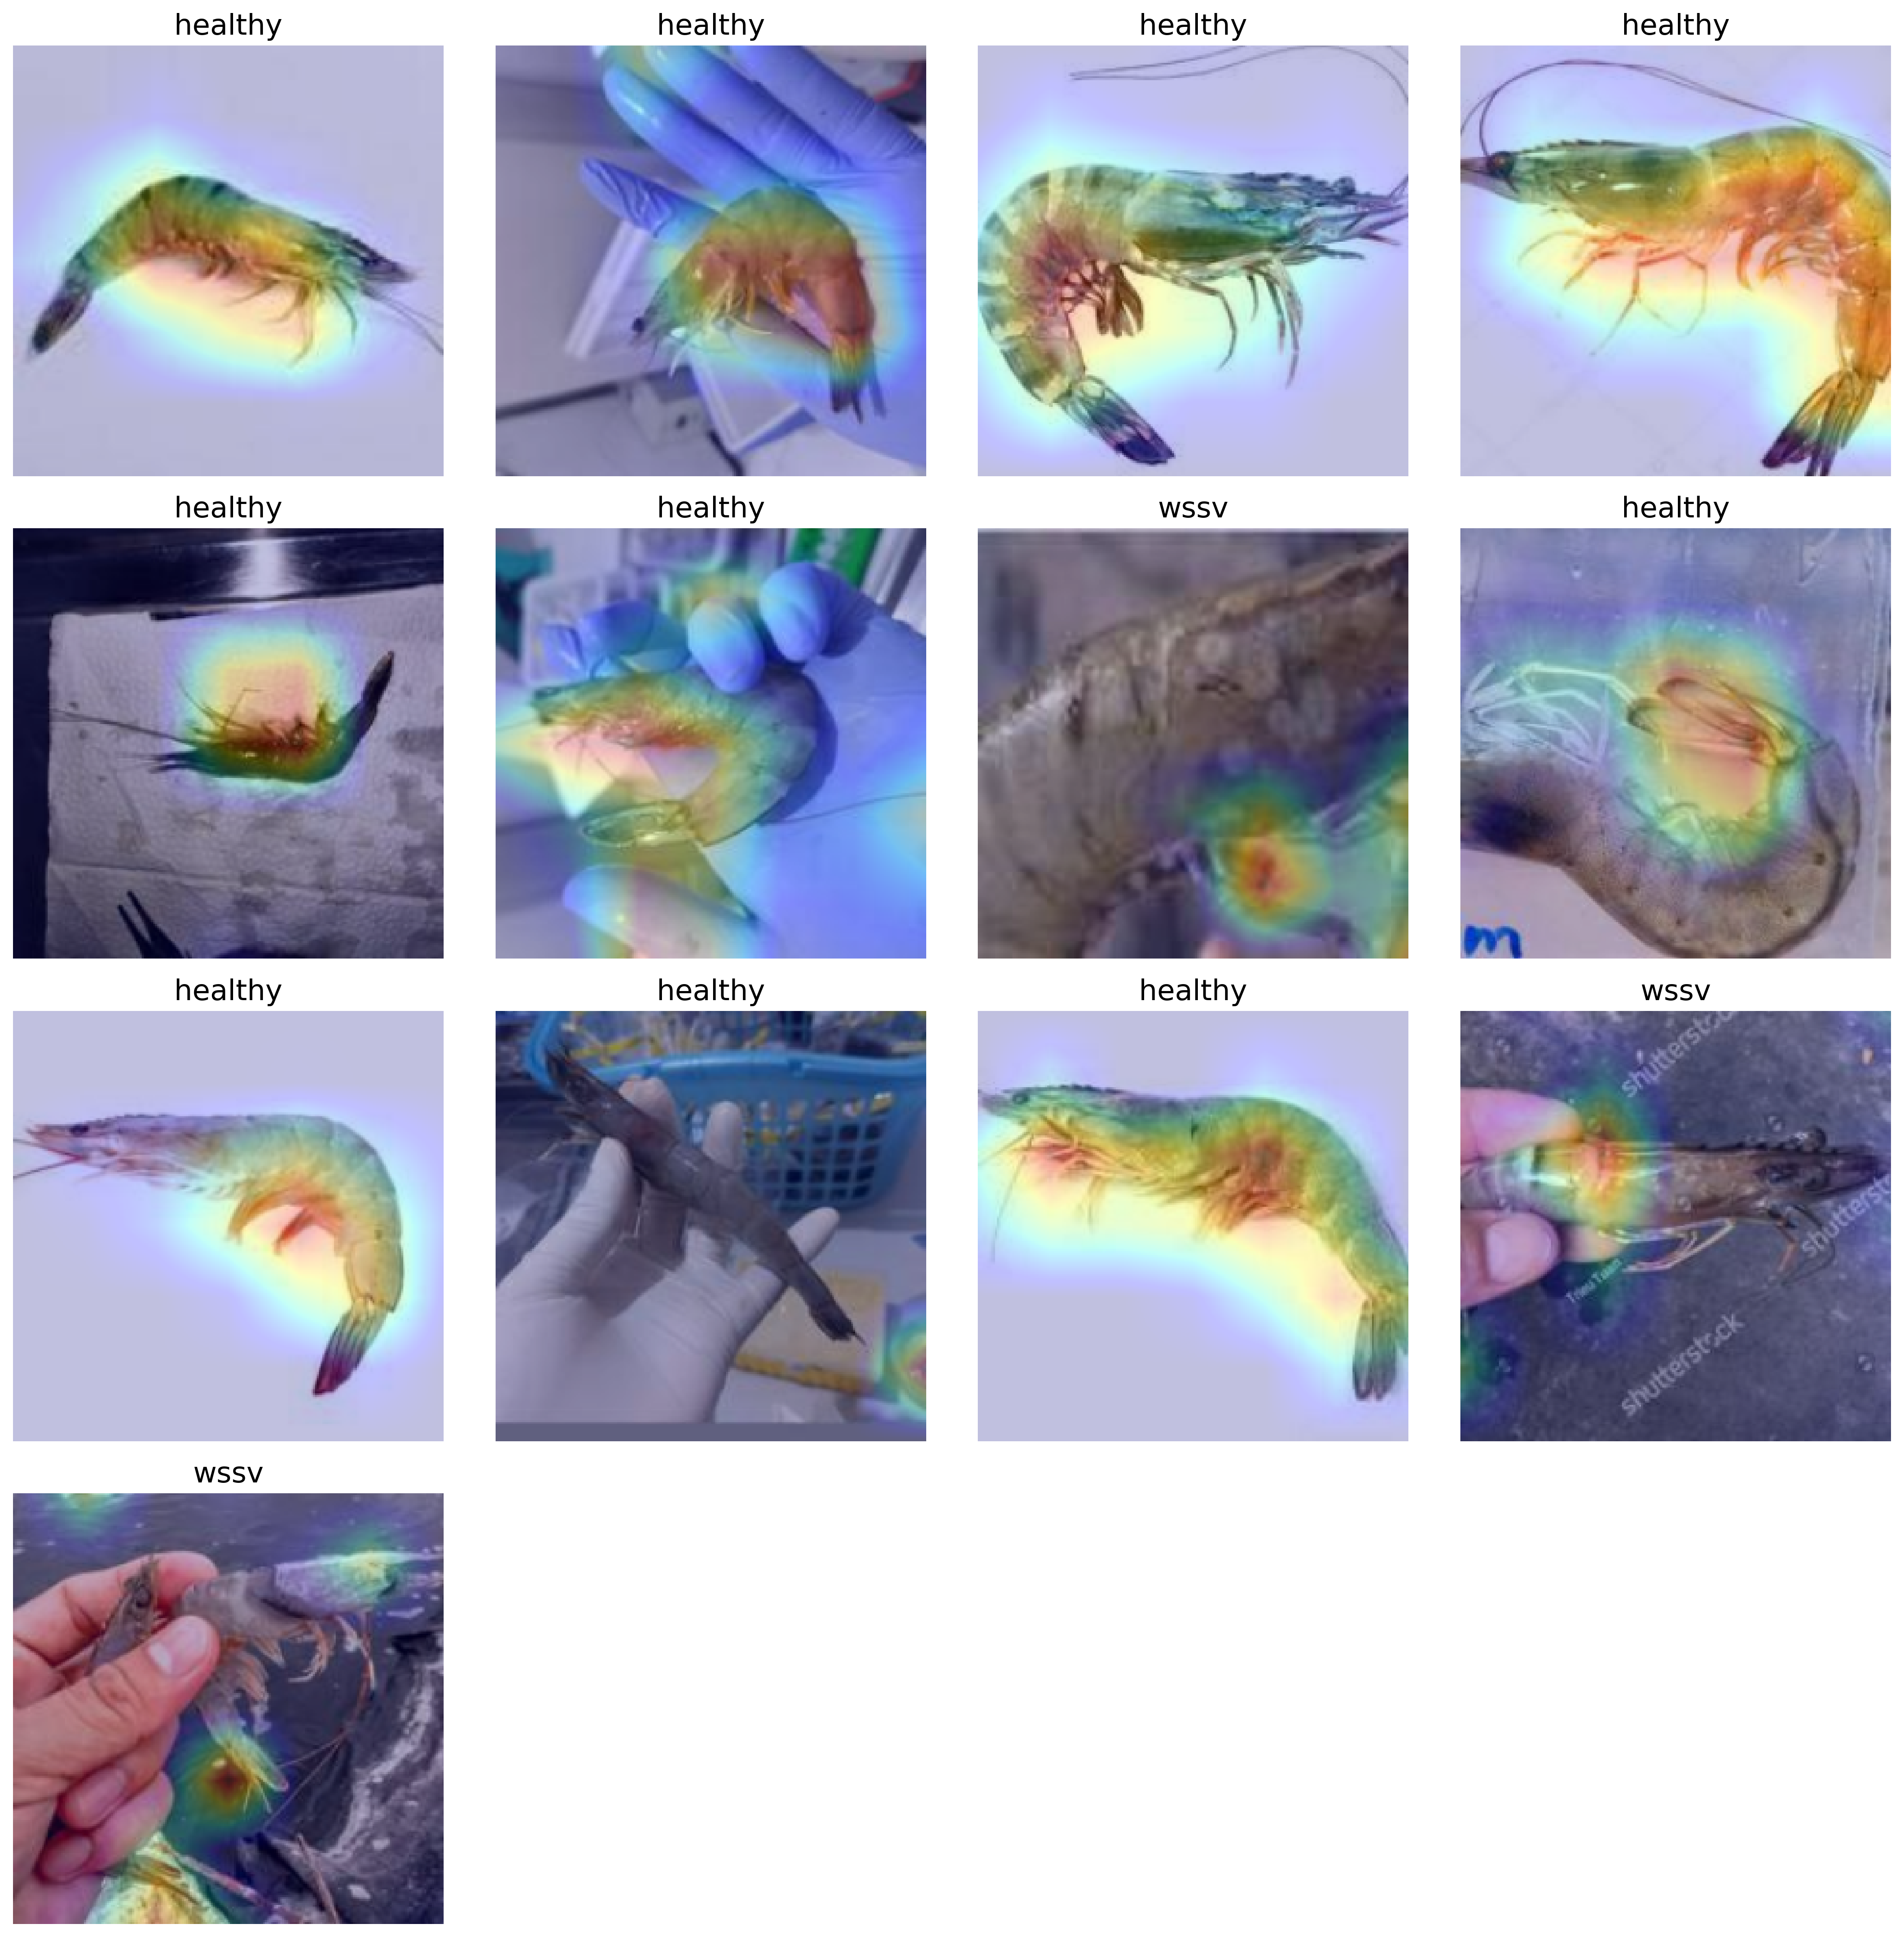

In [10]:
gradcam = GradcamPlusPlus(
    model.get_layer("efficientnetv2-b0"), model_modifier=replace2linear, clone=True
)

cam = gradcam(score, X, penultimate_layer=-1)

plt.figure(figsize=(15, 15), dpi=300)
for i, title in enumerate(test_labels):
    ax = plt.subplot(4, 4, i + 1)
    heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)
    label = CLASS_NAMES[title]
    plt.title(label, fontsize=16)
    plt.imshow(test_images[i] / 255)
    plt.imshow(heatmap, cmap="jet", alpha=0.25)  # overlay
    plt.axis("off")

plt.tight_layout()
plt.show()

In [11]:
checkpoint_filepath = "checkpoints/mobilenetv3small"
latest = tf.train.latest_checkpoint(checkpoint_filepath)

MOBILENET_MODEL = tf.keras.applications.MobileNetV3Small(
    input_shape=CONFIG["input_shape"],
    include_top=False,
    classes=CONFIG["num_classes"],
)

model = create_model(MOBILENET_MODEL, CONFIG)
model.load_weights(latest).expect_partial()

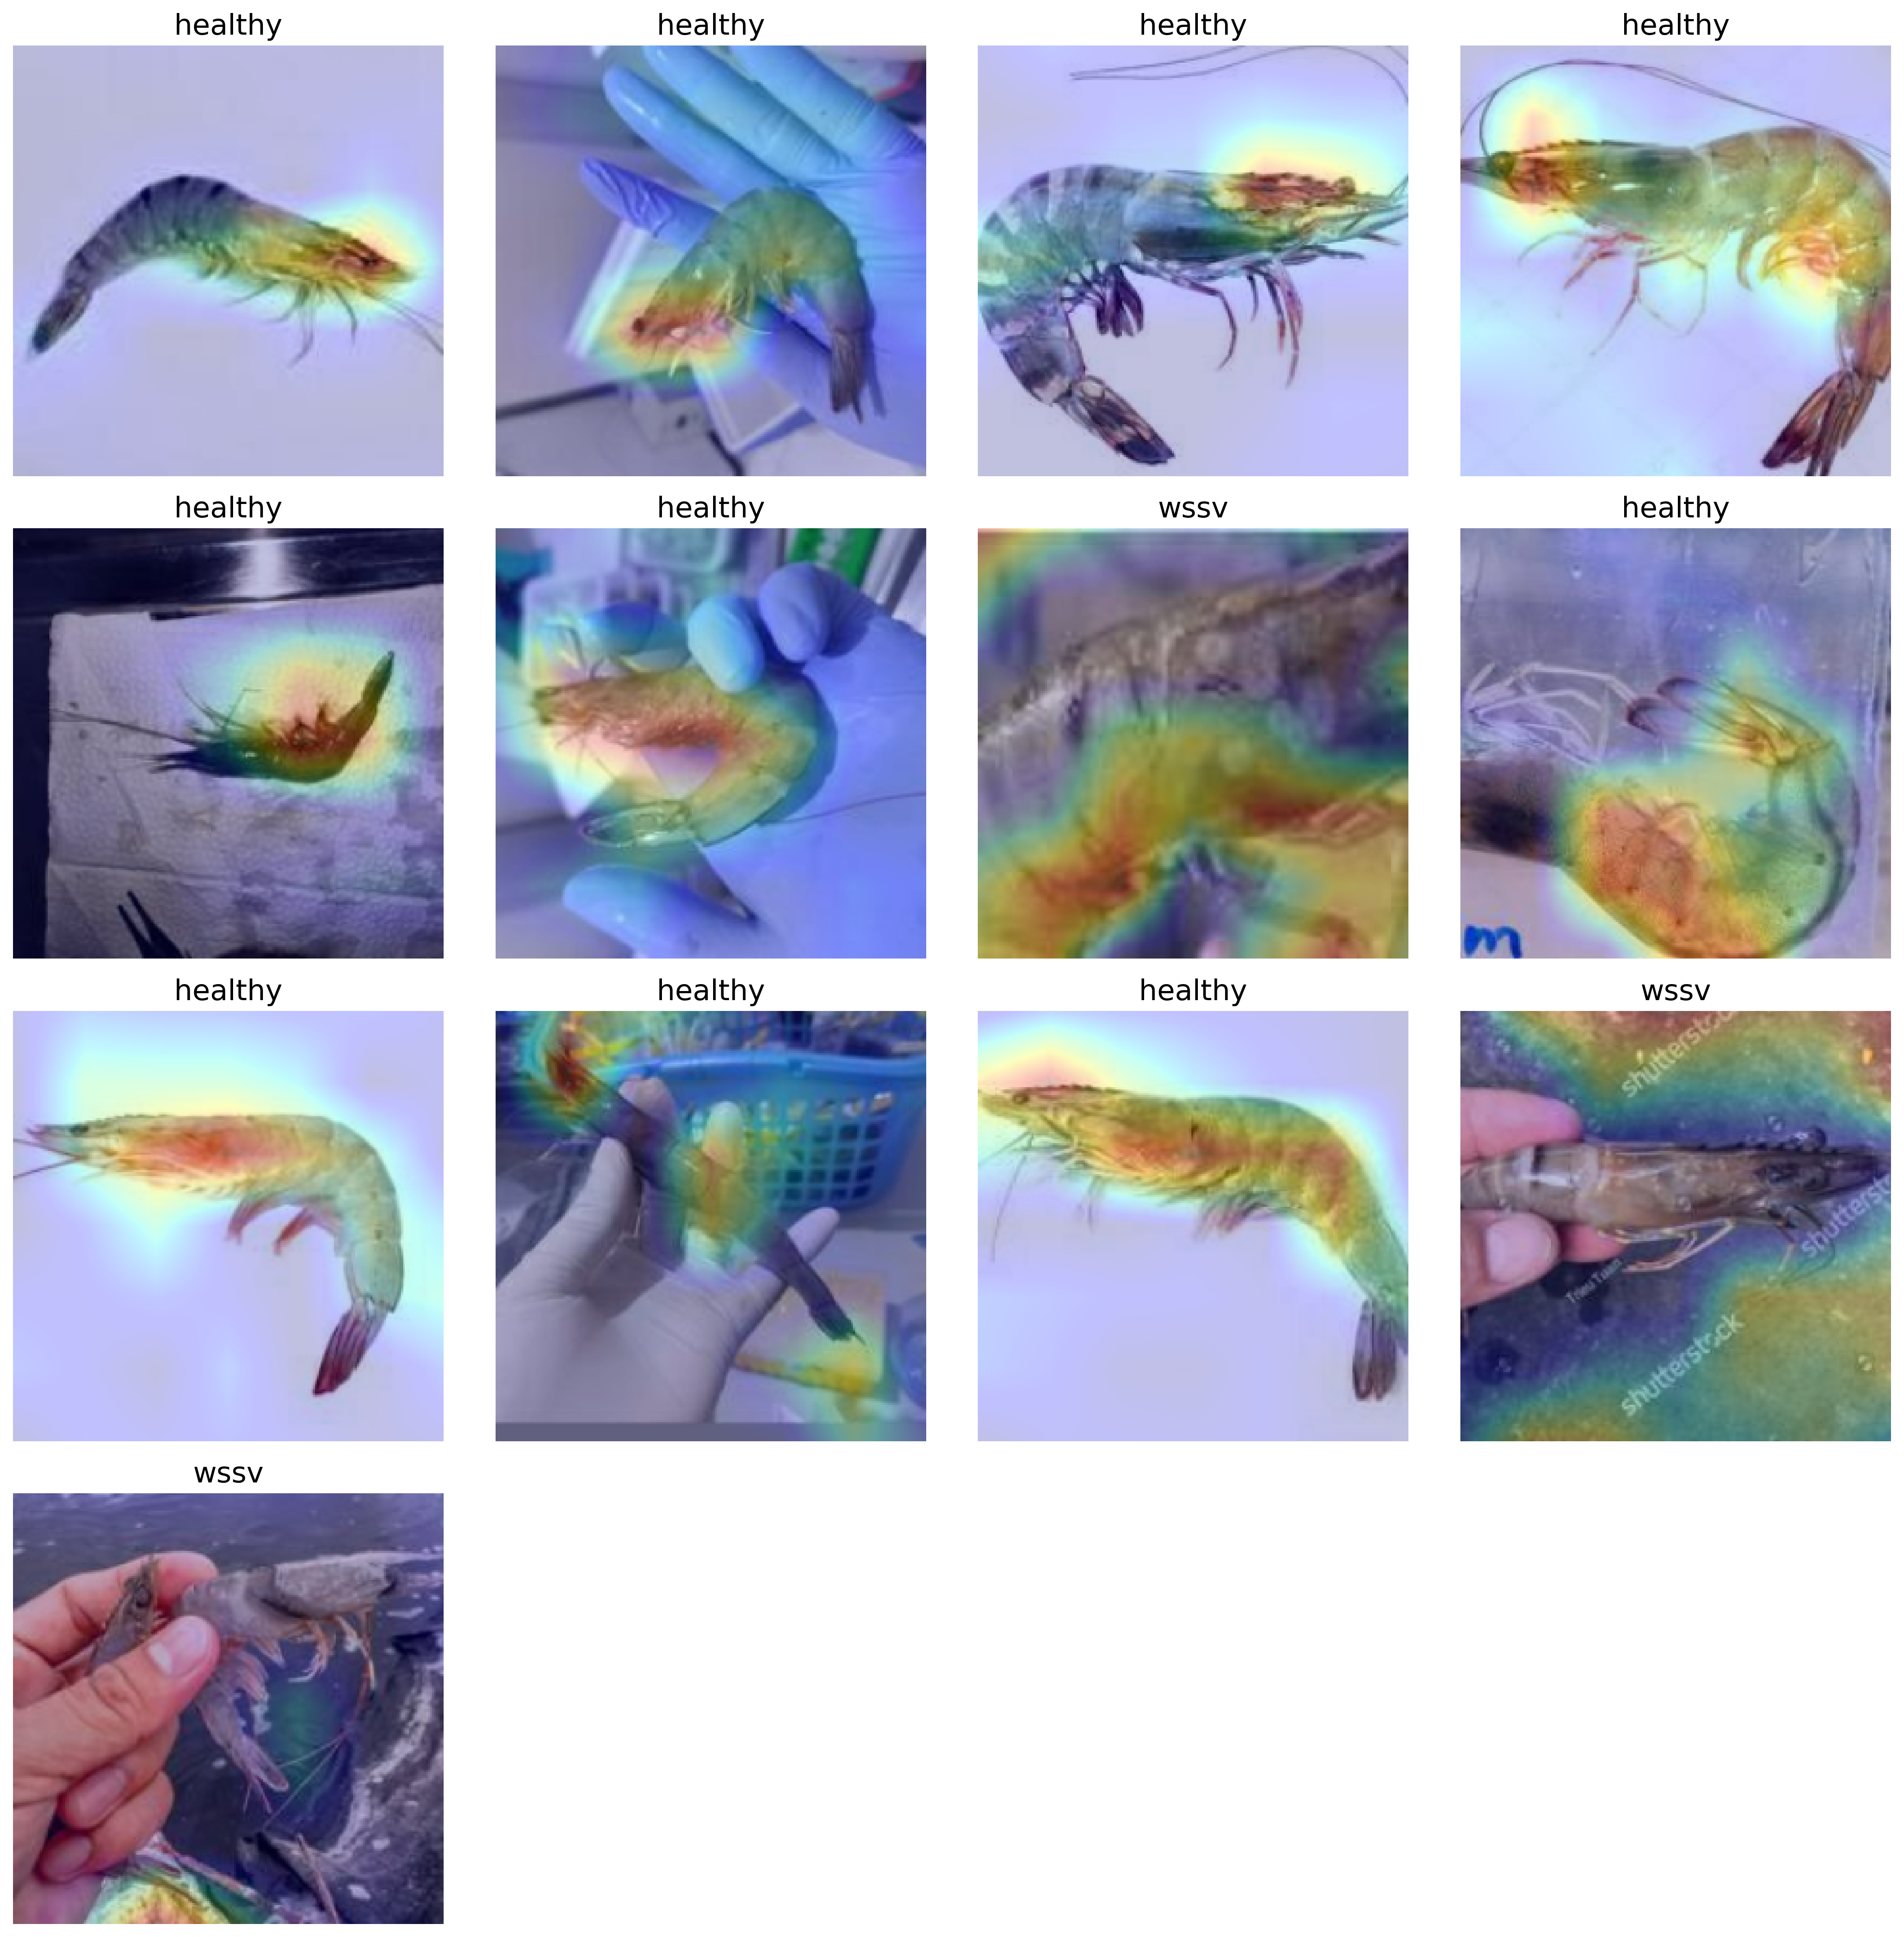

: 

In [13]:
gradcam = GradcamPlusPlus(
    model.get_layer("MobilenetV3small"), model_modifier=replace2linear, clone=True
)

cam = gradcam(score, X, penultimate_layer=-1)

plt.figure(figsize=(15, 15), dpi=300)
for i, title in enumerate(test_labels):
    ax = plt.subplot(4, 4, i + 1)
    heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)
    label = CLASS_NAMES[title]
    plt.title(label, fontsize=16)
    plt.imshow(test_images[i] / 255)
    plt.imshow(heatmap, cmap="jet", alpha=0.25)  # overlay
    plt.axis("off")

plt.tight_layout()
plt.show()